In [186]:
import torch
import torchvision
import torchvision.models.segmentation.deeplabv3 as dlv3
import torchvision.transforms.functional as tf
import numpy as np
import data
import utils
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [187]:
def map_scalars_to_colors(scalars_mask, pixel_mapping):
    colors_mask = Image.new(mode="RGB", size=(scalars_mask.size[0], scalars_mask.size[1]))
    for i in range(scalars_mask.size[0]):
        for j in range(scalars_mask.size[1]):
            p =  scalars_mask.getpixel((i,j))
            colors_mask.putpixel((i,j), pixel_mapping[scalars_mask.getpixel((i,j))])
    return colors_mask

In [188]:
model_parameters_load_path = r'G:\My Drive\Master IVA\Master Thesis\Models\20230415_201623_real_train_check_original_validation_dataset_no_augmentation\deeplabv3_model.pt'
    
ipt_path = r'G:\My Drive\Master IVA\Master Thesis\Datasets\real\train\rgb\real_rgb_2971.png'
tgt_path = r'G:\My Drive\Master IVA\Master Thesis\Datasets\real\train\semantic_segmentation_mapped\real_semantic_segmentation_2971.png'

num_classes = len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys())
infer_width_resize = 512
infer_height_resize = 256

In [189]:
# Input preparation
pil_ipt = Image.open(f'{ipt_path}', mode='r')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((infer_height_resize, infer_width_resize))])
ipt = tf.to_tensor(np.array(pil_ipt))
ipt = transform(ipt)
pil_ipt = pil_ipt.resize((infer_width_resize, infer_height_resize), resample=Image.Resampling.NEAREST)

# Target preparation
pil_tgt = Image.open(f'{tgt_path}', mode='r',)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((infer_height_resize, infer_width_resize))])
tgt = Image.open(tgt_path, 'r',)
tgt = np.array(tgt).astype(np.int_)
tgt = tf.to_tensor(tgt)
tgt = transform(tgt)
pil_tgt = pil_tgt.resize((infer_width_resize, infer_height_resize), resample=Image.Resampling.NEAREST)

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = dlv3.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=17)
model.load_state_dict(torch.load(model_parameters_load_path))
model.eval()
model.to(device)
print('Loaded model to device.')

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded model to device.


In [191]:
pred = model(ipt.to(device, non_blocking=True).unsqueeze(0))['out']
pred = torch.argmax(pred.cpu(), dim=1)
pred = pred.to(torch.uint8) 

In [192]:
pil_pred = torchvision.transforms.ToPILImage()(pred)

In [193]:
pil_pred_colors_mask = map_scalars_to_colors(pil_pred, data.SemanticLabelMapper.ID_TO_COLOR['common'])
pil_tgt_colors_mask = map_scalars_to_colors(pil_tgt, data.SemanticLabelMapper.ID_TO_COLOR['common'])

In [194]:

from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

rgb_pred_blend = Image.blend(pil_ipt, pil_pred_colors_mask, 0.9)
rgb_tgt_blend = Image.blend(pil_ipt, pil_pred_colors_mask, 0.9)

label_rectangles = []
for c in data.SemanticLabelMapper.ID_TO_COLOR['common'].values():
    c_normalized = [c_val / 255.0 for c_val in c]
    label_rectangles += [Rectangle((0,0), width=1, height=1, color=tuple(c_normalized))]

label_names = [v for v in data.SemanticLabelMapper.ID_TO_STRING['common'].values()]


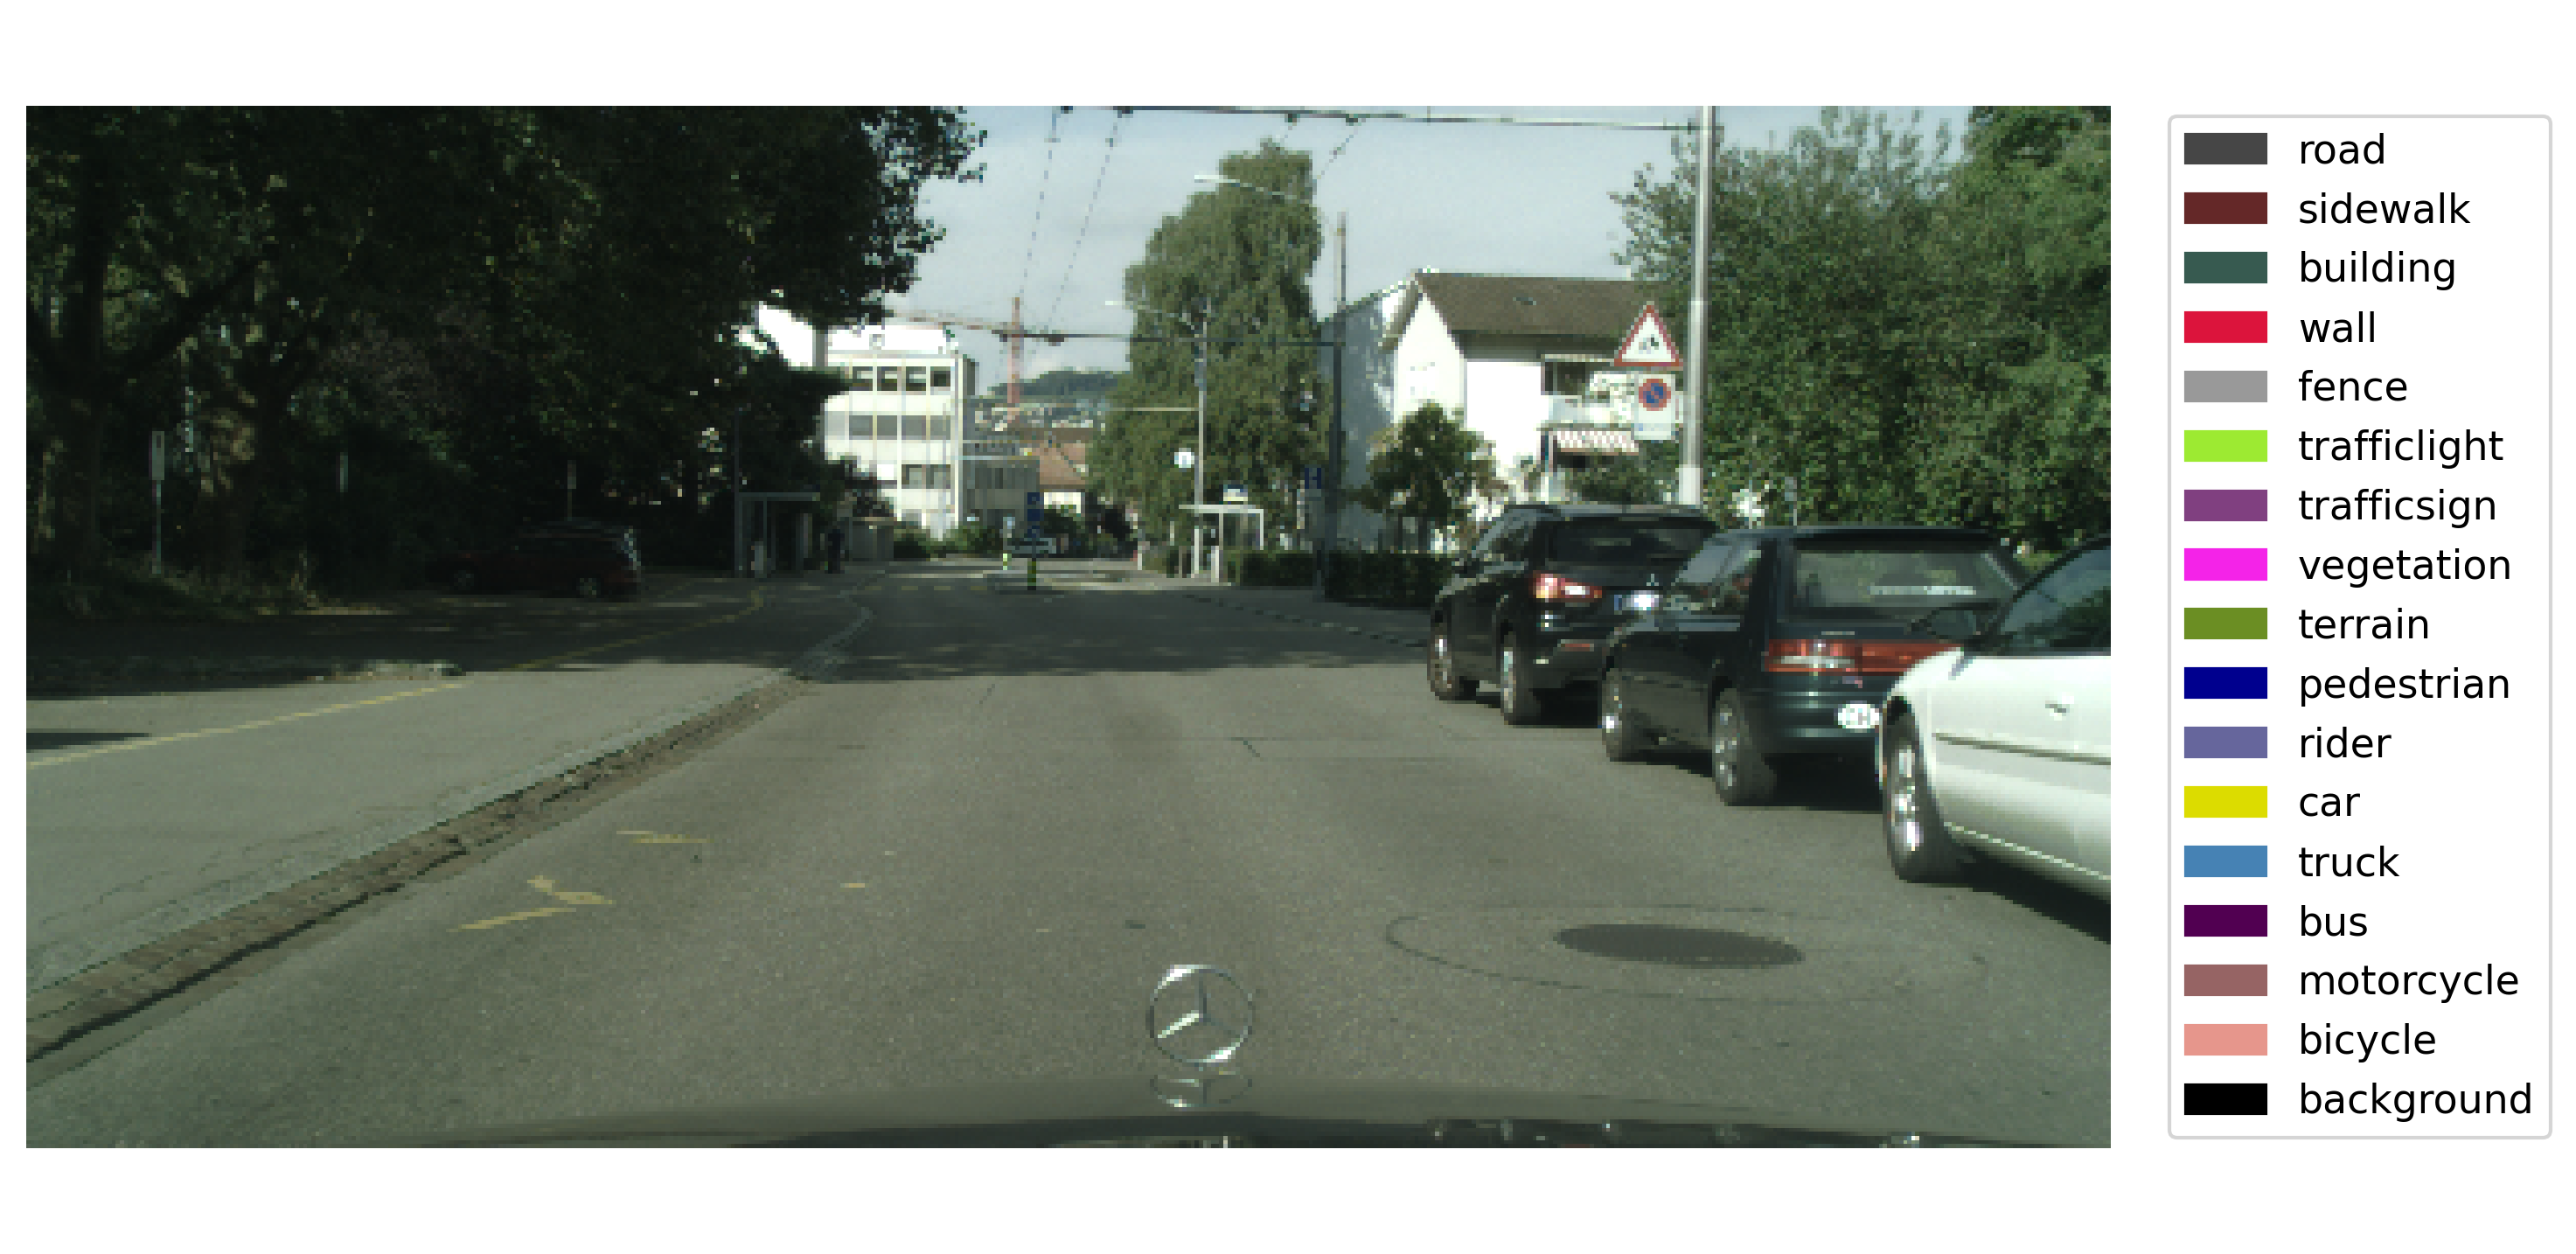

In [195]:
fig, ax = plt.subplots(1, 2, dpi=300, gridspec_kw={'width_ratios': [10, 1]}, figsize=(10,5))
ax[0].imshow(np.array(pil_ipt), interpolation='nearest')
ax[1].legend(label_rectangles,label_names, ncol=1, fontsize=11, loc='center')
ax[1].axis('off')
ax[0].axis('off')
fig.tight_layout()

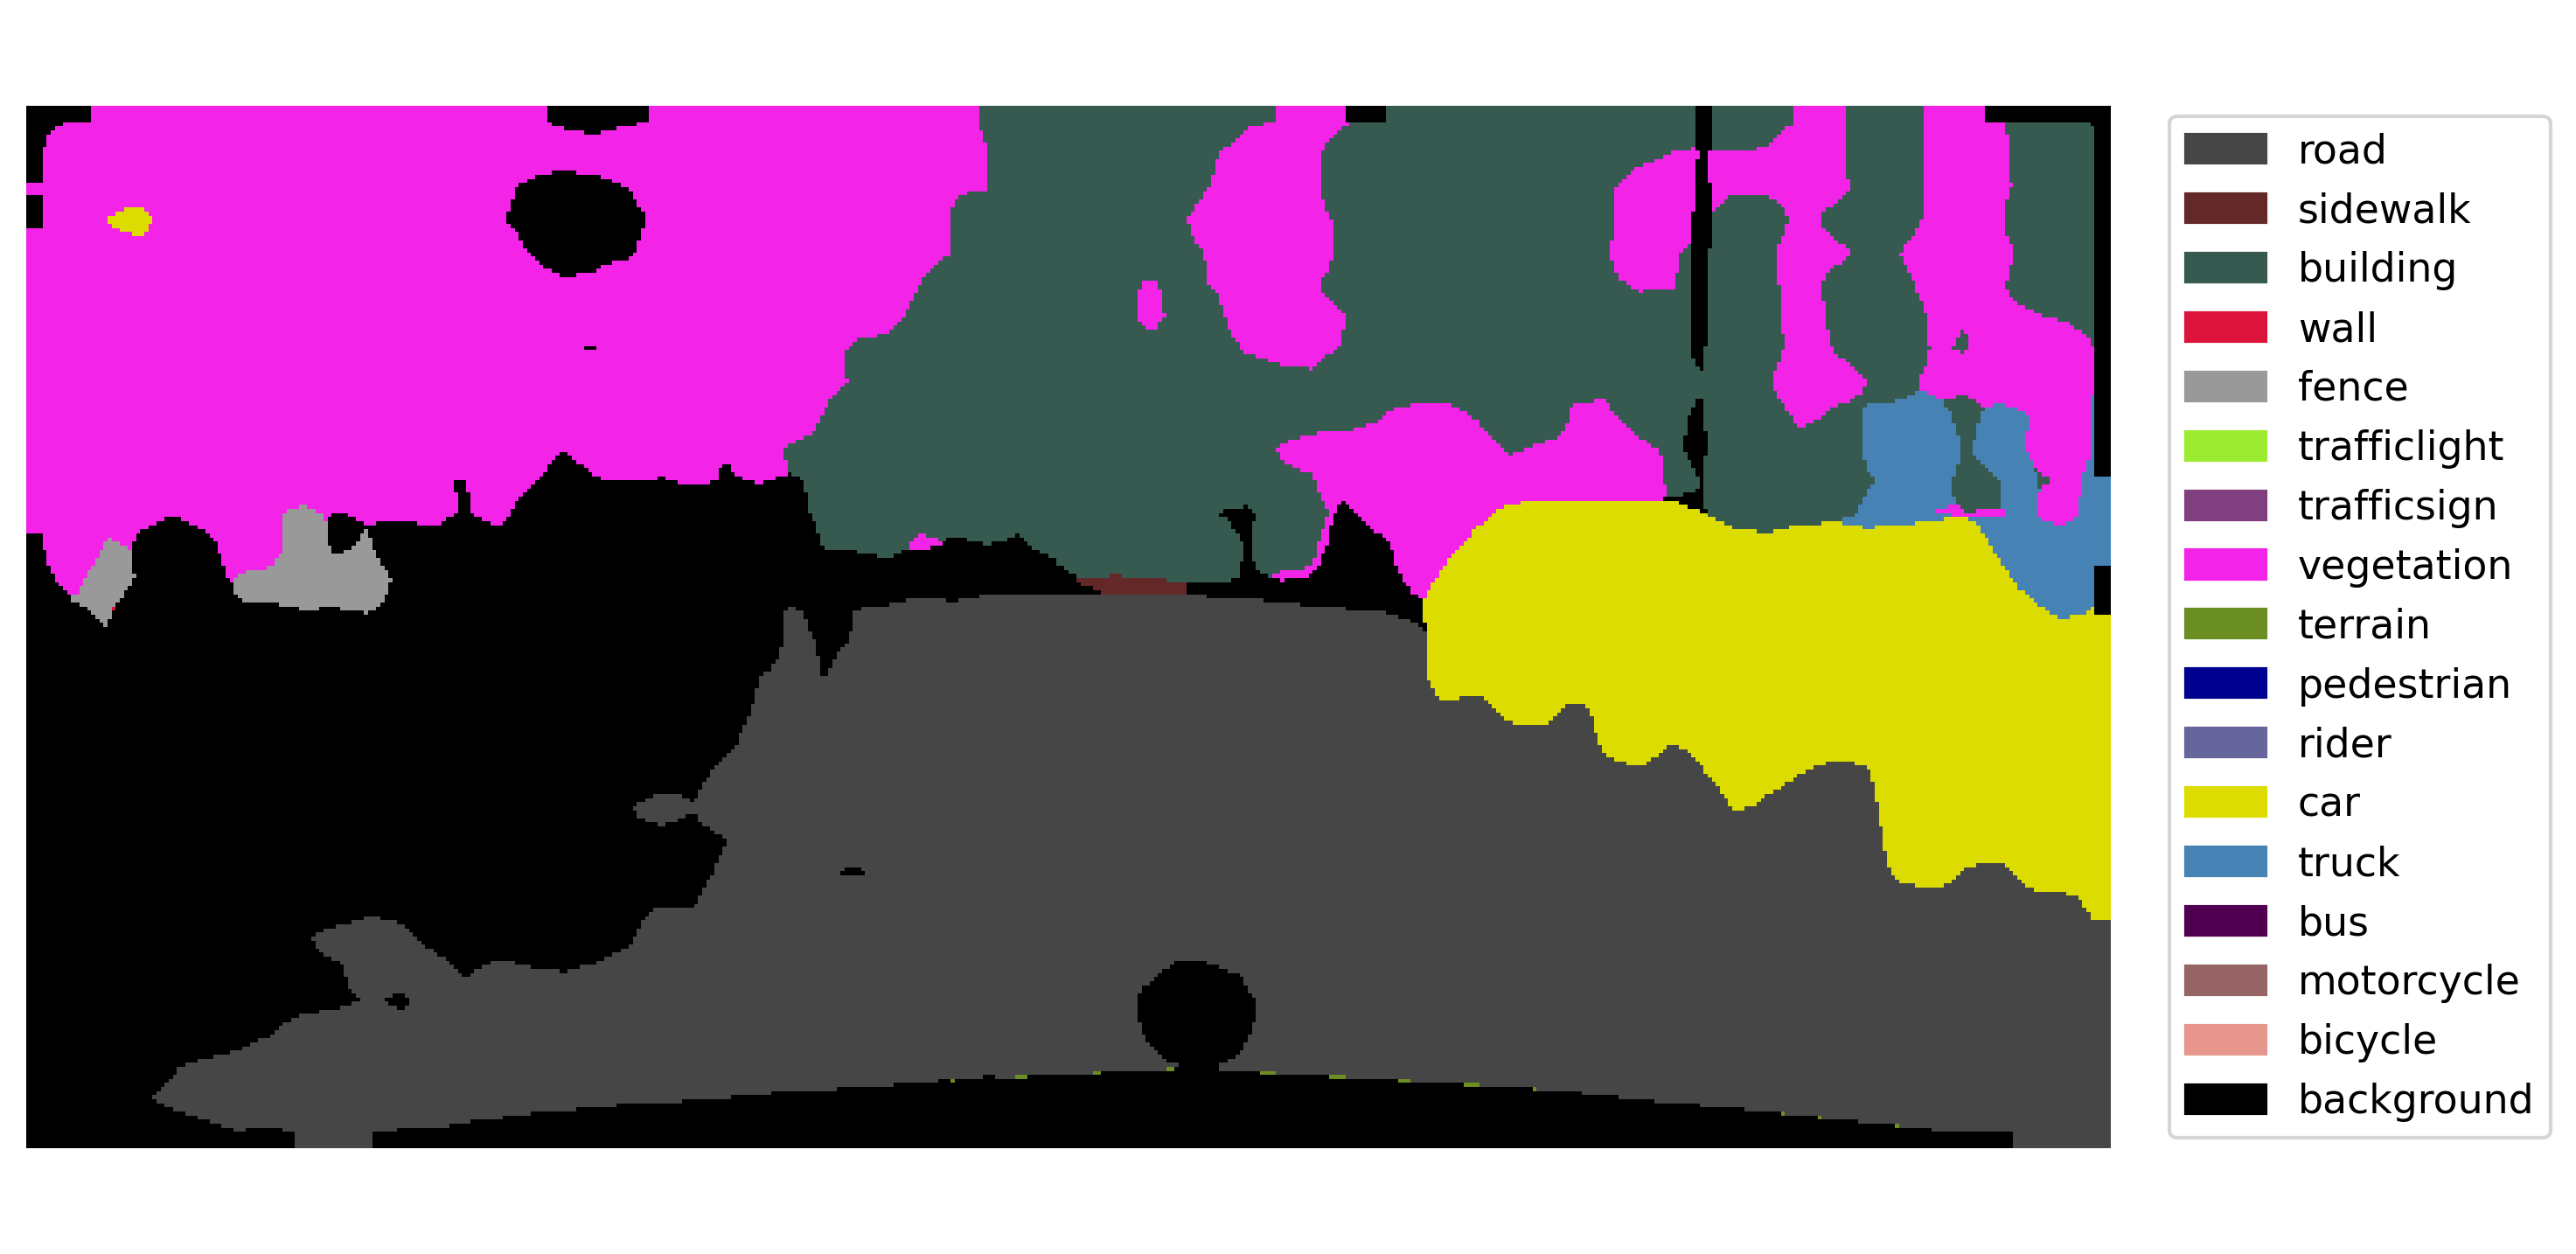

In [196]:
# Show the PREDICTED semantic segmentation mask
fig.clear()
fig, ax = plt.subplots(1, 2, dpi=300, gridspec_kw={'width_ratios': [10, 1]}, figsize=(10,5))
ax[0].imshow(np.array(pil_pred_colors_mask), interpolation='nearest')
ax[1].legend(label_rectangles,label_names, ncol=1, fontsize=11, loc='center')
ax[1].axis('off')
ax[0].axis('off')
fig.tight_layout()

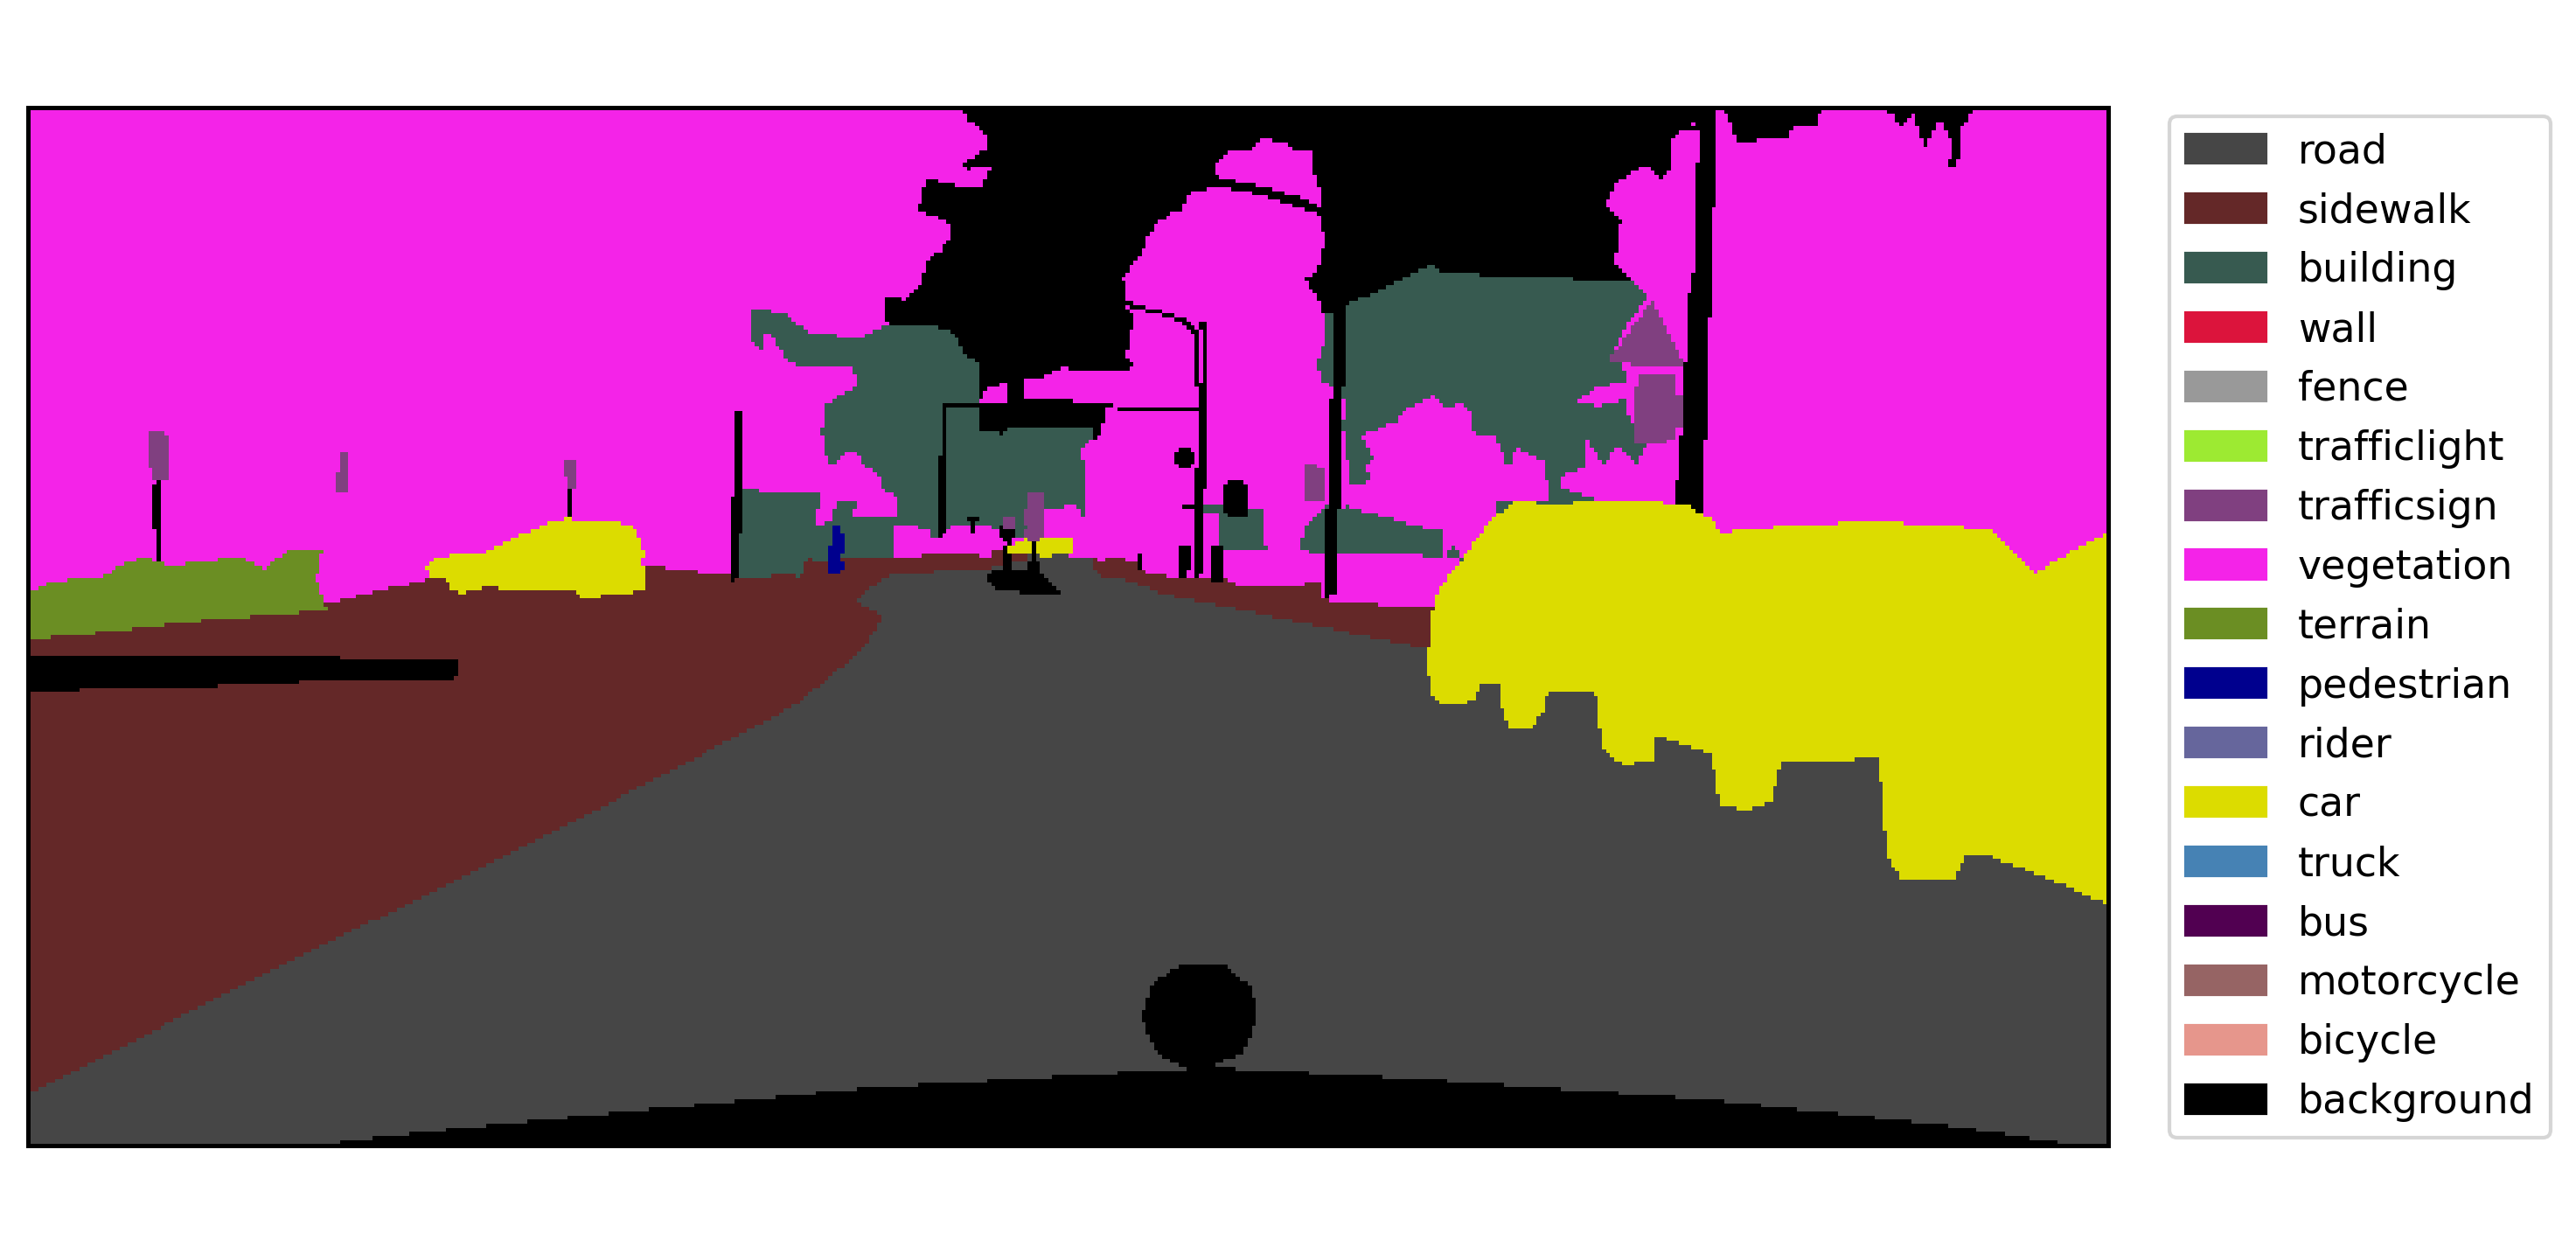

In [197]:
fig.clear()
fig, ax = plt.subplots(1, 2, dpi=300, gridspec_kw={'width_ratios': [10, 1]}, figsize=(10,5))
ax[0].imshow(np.array(pil_tgt_colors_mask), interpolation='nearest')
ax[1].legend(label_rectangles,label_names, ncol=1, fontsize=11, loc='center')
ax[1].axis('off')
ax[0].axis('off')
fig.tight_layout()

In [198]:
# ignore_label = 19
with torch.no_grad():
    
    confusion_mat = utils.compute_confusion_matrix(predictions=pred, targets=tgt, num_classes=len(data.SemanticLabelMapper.ID_TO_COLOR['common'].keys()))
    miou, ious = utils.measure_performance(confusion_mat=confusion_mat, num_classes=len(data.SemanticLabelMapper.ID_TO_COLOR['common'].keys()), ignore_label=None)

    print(f'Mean IoU: {miou}')
    print(f'IoUs: {ious}')
    

Mean IoU: 0.1701912038616925
IoUs: [ 8.67799834e-01  2.88813750e-03  1.97316668e-01  3.89551938e-18
  2.34719456e-19  3.17206578e-17  3.26536184e-19  6.23950928e-01
  1.65581361e-19  1.02324703e-18  1.38777878e-17  8.50071195e-01
  1.09381579e-19 -1.00000000e+00  3.46944695e-18  2.22044605e-16
  1.81032499e-01]
